### EDA

In [1]:
library(cowplot) #Installing package into 'C:/Users/User/Documents/R/win-library/4.0'
library(grid)
library(ggplot2)
library(ggExtra)
library(tidyverse)
library(lubridate)
library(gridExtra)
library(pROC)
library(ROCR)
library(ROCit)
library(caret)
library(boot)
library(gbm)
# library("cvAUC")

library(MLmetrics)

Warning message:
"package 'cowplot' was built under R version 4.0.5"
Warning message:
"package 'ggplot2' was built under R version 4.0.5"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following object is masked from 'package:cowplot':

    stamp


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Loading required package: lattice


Attaching

In [2]:
# directories
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"
modeldir4 = "../../OutputTD/3_models/1_4_cohort"
# modeldir4preadmit = "../../OutputTD/3_models/1_4_cohort_24hrpreadmit"
tabledir = "../../OutputTD/4_tables"
resultdir = "../../OutputTD/5_results_analysis"

options(repr.matrix.max.rows=200, repr.matrix.max.cols=30)

In [3]:
cohort <- read.csv(file.path(cohortdir, "1_4_cohort.csv")) %>% mutate(admit_time = ymd_hms(admit_time))
nrow(cohort)

demo <- read.csv(file.path(featuredir, "2_1_coh2_demo.csv"))  %>% mutate(admit_time = ymd_hms(admit_time)) %>% 
            select(anon_id, pat_enc_csn_id_coded, race)
nrow(demo)

esi <- read.csv(file.path(featuredir, "2_5_coh3_imputedHWESI.csv"))  %>% mutate(admit_time = ymd_hms(admit_time)) %>%
            select(anon_id, pat_enc_csn_id_coded, ESI_i) %>% rename(ESI = ESI_i)
nrow(esi)

los <- read.csv(file.path(datadir, "length_of_stay_labels.csv")) %>% mutate(admit_time = ymd_hms(admit_time))
nrow(los) # less than cohort

# adm_year = year(admit_time)

[1] 43980

[1] 45794

[1] 44258

[1] 43765

In [5]:
head(cohort,1)
head(demo,1)
head(esi)
head(los)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,JCd97296,1.31176e+11,18290644,2016-02-06 22:31:00,0,0,NA,0,0,0,0,0,1325,0,0,0,0


,anon_id,pat_enc_csn_id_coded,race
,<chr>,<dbl>,<chr>
1,JC29f8ad2,131274729058,White


,anon_id,pat_enc_csn_id_coded,ESI
,<chr>,<dbl>,<int>
1,JC29f8ad2,131274729058,3
2,JC29f8ad3,131278291027,3
3,JC29f8b9c,131266787806,2
4,JC29f8beb,131264387263,3
5,JC29f8beb,131279241689,3
6,JC29f8bef,131280937356,3


,anon_id,pat_enc_csn_id_coded,admit_time,first_ED_time,discharge_time,length_of_ip_since_admit,length_from_ED_entry_until_discharge,death_date_jittered,died_before_discharge
,<chr>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,JCe78a06,131062667066,2015-01-02 01:01:00,2015-01-01 17:10:00+00:00,2015-01-11 23:40:00+00:00,9 days 22:39:00,10 days 06:30:00,2020-01-10 00:00:00+00:00,
2,JCd1c19e,131062745090,2015-01-03 05:53:00,2015-01-03 01:56:00+00:00,2015-01-07 02:00:00+00:00,3 days 20:07:00,4 days 00:04:00,,
3,JCd91eb2,131062747648,2015-01-01 08:24:00,2015-01-01 01:10:00+00:00,2015-01-06 03:19:00+00:00,4 days 18:55:00,5 days 02:09:00,2019-01-01 00:00:00+00:00,
4,JCe7cb4d,131062788358,2015-01-01 23:39:00,2015-01-01 17:07:00+00:00,2015-01-22 01:25:00+00:00,20 days 01:46:00,20 days 08:18:00,,
5,JCe293de,131063044001,2015-01-05 02:23:00,2015-01-04 18:13:00+00:00,2015-01-05 22:30:00+00:00,0 days 20:07:00,1 days 04:17:00,,
6,JCe8d756,131063080858,2015-01-07 04:00:00,2015-01-06 22:24:00+00:00,2015-01-09 21:00:00+00:00,2 days 17:00:00,2 days 22:36:00,,


### check ESI by race

Joining, by = c("anon_id", "pat_enc_csn_id_coded")

Joining, by = c("anon_id", "pat_enc_csn_id_coded")



[1] 43980

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:43980       Min.   :1.311e+11    Min.   :13616753       
 Class :character   1st Qu.:1.312e+11    1st Qu.:19861137       
 Mode  :character   Median :1.312e+11    Median :27876162       
                    Mean   :1.312e+11    Mean   :28124485       
                    3rd Qu.:1.313e+11    3rd Qu.:34360245       
                    Max.   :1.313e+11    Max.   :48026130       
                                                                
   admit_time                   label_max24     label_24hr_recent
 Min.   :2015-01-01 08:24:00   Min.   :0.0000   Min.   :0.0000   
 1st Qu.:2016-05-21 21:18:15   1st Qu.:0.0000   1st Qu.:0.0000   
 Median :2017-12-29 20:46:30   Median :0.0000   Median :0.0000   
 Mean   :2017-10-11 23:21:00   Mean   :0.1353   Mean   :0.0945   
 3rd Qu.:2019-02-17 03:08:45   3rd Qu.:0.0000   3rd Qu.:0.0000   
 Max.   :2020-03-31 07:00:00   Max.   :1.0000   Max.   :1.0000   
                  

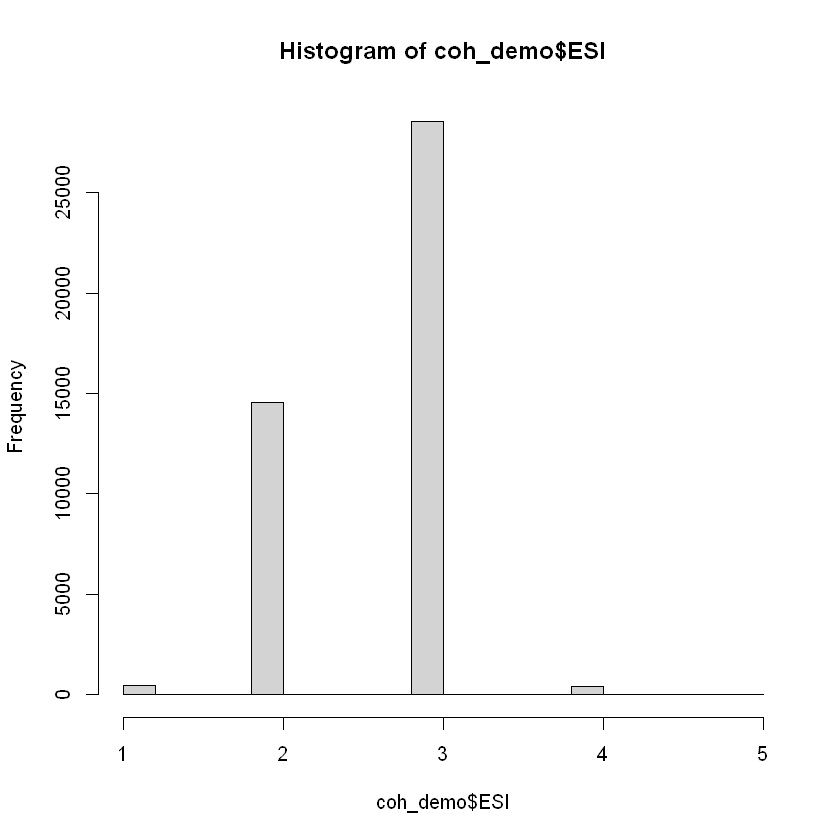

In [7]:
coh_demo <- left_join(cohort, demo) %>% left_join(esi) %>% mutate(race=factor(race))
nrow(coh_demo)
summary(coh_demo)

hist(coh_demo$ESI)

In [8]:
race_esi <- coh_demo %>% group_by(race, ESI) %>% summarise(n = n()) %>% 
                group_by(race) %>% mutate(ntotal = sum(n), group_percentage = round(100*n/ntotal, 2))
race_esi

`summarise()` regrouping output by 'race' (override with `.groups` argument)



race,ESI,n,ntotal,group_percentage
<fct>,<int>,<int>,<int>,<dbl>
Asian,1,69,6655,1.04
Asian,2,2307,6655,34.67
Asian,3,4224,6655,63.47
Asian,4,53,6655,0.80
Asian,5,2,6655,0.03
Black,1,43,3104,1.39
Black,2,1084,3104,34.92
Black,3,1938,3104,62.44
Black,4,36,3104,1.16


In [9]:
color_table <- tibble(
  race = c("Asian", "Black", "Native American", "Other", "Pacific Islander", "Unknown", "White"),
  color = c("tan", "grey30", "salmon4", "magenta3", "tan3", "limegreen", "moccasin")
  )
color_table5 <- tibble(
  race = c("Asian", "Black", "Other", "White"),
  color = c("tan", "grey30", "magenta3", "moccasin")
  )

race_esi1 <- race_esi %>% filter(ESI==1)
race_esi23 <- race_esi %>% filter(ESI==2 | ESI==3)
race_esi4 <- race_esi %>% filter(ESI==4)
race_esi5 <- race_esi %>% filter(ESI==5)

race_esi5

race,ESI,n,ntotal,group_percentage
<fct>,<int>,<int>,<int>,<dbl>
Asian,5,2,6655,0.03
Black,5,3,3104,0.10
Other,5,4,10170,0.04
White,5,7,22580,0.03


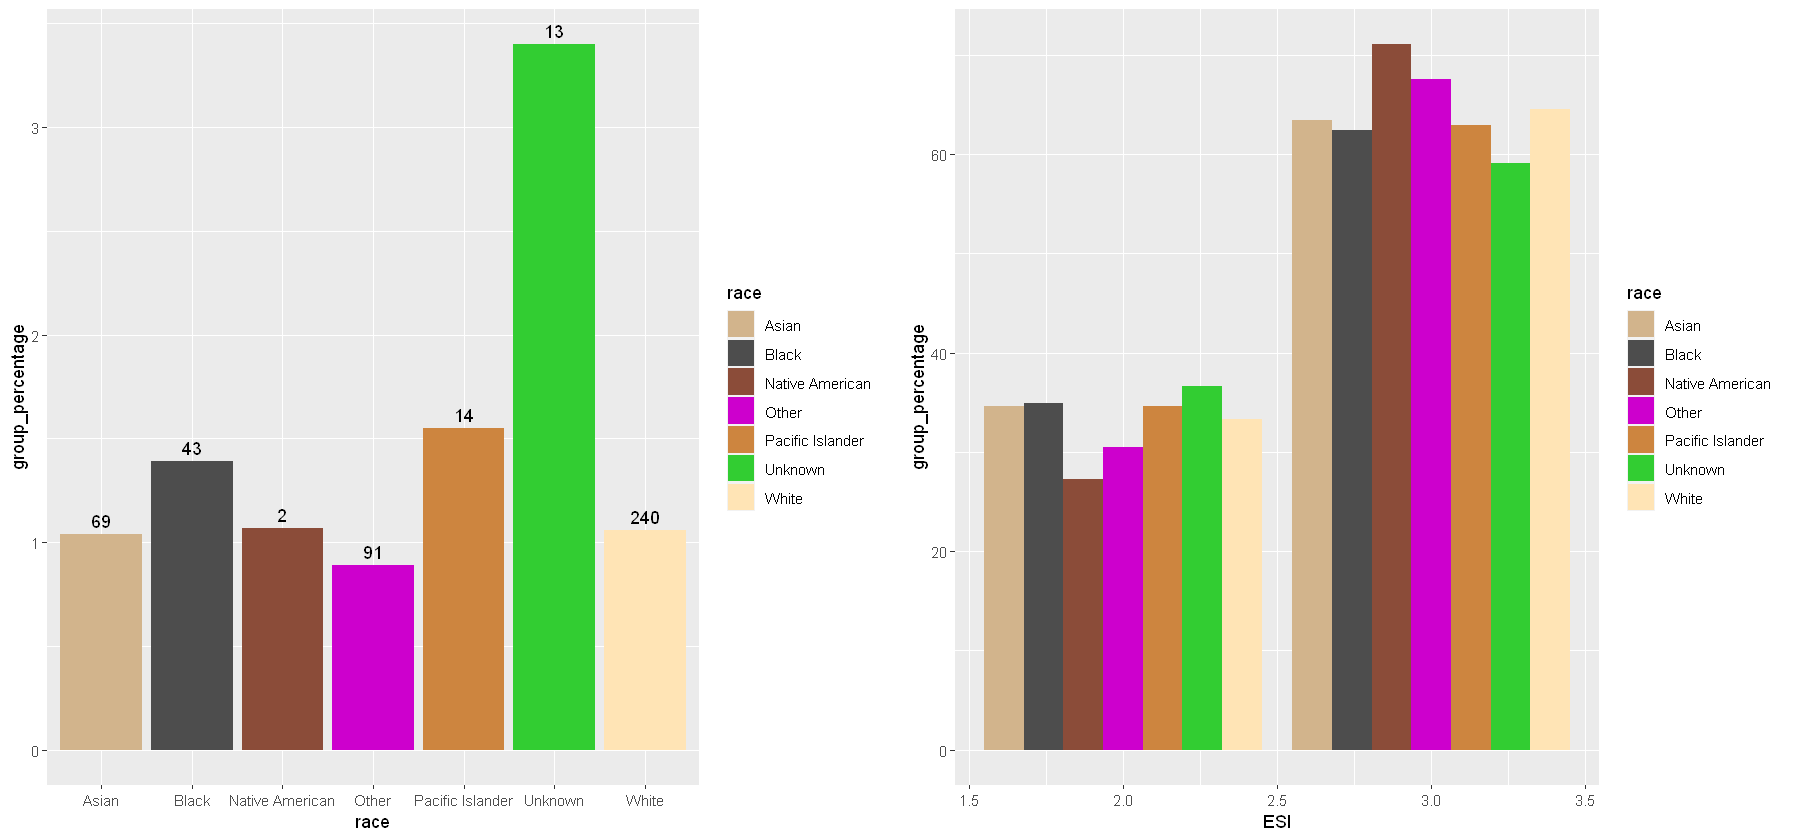

In [9]:
options(repr.plot.width=15, repr.plot.height=7)

p1 <- ggplot(race_esi1, aes(fill=race, y=group_percentage, x=race)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = color_table$color) +
    geom_text(aes(label=n), position=position_dodge(width=1), vjust=-0.5)

p23 <- ggplot(race_esi23, aes(fill=race, y=group_percentage, x=ESI)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = color_table$color) #+
#     geom_text(aes(label=n), position=position_dodge(width=1), vjust=0, angle=90)

grid.arrange(p1, p23, ncol=2)
ggsave(file.path(resultdir,"Fig_ESI123.png"), width = 15, height = 7, dpi = 1200) 

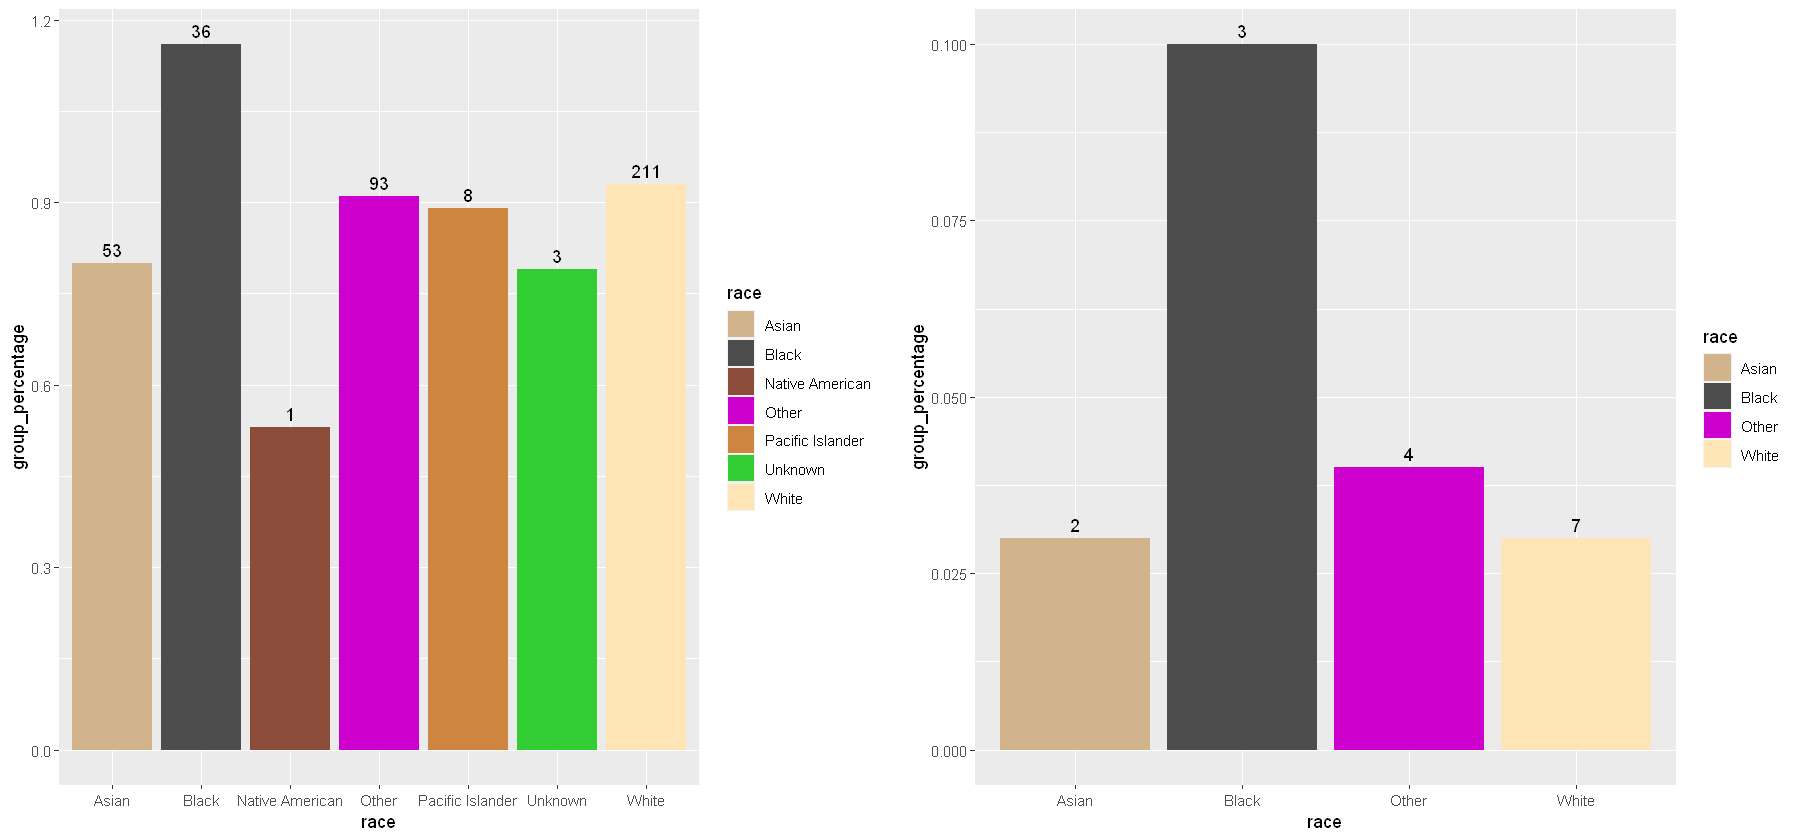

In [10]:
p4 <- ggplot(race_esi4, aes(fill=race, y=group_percentage, x=race)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = color_table$color) +
    geom_text(aes(label=n), position=position_dodge(width=1), vjust=-0.5)

p5 <- ggplot(race_esi5, aes(fill=race, y=group_percentage, x=race)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = color_table5$color) +
    geom_text(aes(label=n), position=position_dodge(width=1), vjust=-0.5)

grid.arrange(p4, p5, ncol=2)
# plotlist <- list(p4, p5)
# plot_grid(plotlist=plotlist)
ggsave(file.path(resultdir,"Fig_ESI45.png"), width = 15, height = 7, dpi = 1200) 

### density plot of predicted probabilities for test cohort


In [10]:
coh_test <- read.csv(file.path(modeldir4, "1_4_cohort_test_results.csv")) %>% 
                select(pat_enc_csn_id_coded, first_label, death_24hr_max_label, death_24hr_recent_label, 
                       pred_first, pred_death_24hr_max, pred_death_24hr_recent, abs_diff0_24, transfer)
nrow(coh_test)

# preds_max <- coh_test %>% select(outcome = death_24hr_max_label, prediction = pred_death_24hr_max)
# preds_24hr <- coh_test %>% select(outcome = death_24hr_recent_label, prediction = pred_death_24hr_recent)

[1] 12418

In [11]:
### Plot function, using data0
plotfxn <- function(X, Xlab, Fill, data){
#     p0 <- data %>% ggplot(aes(x=X)) + geom_density() + facet_wrap(~race_recoded) # unable to use Fill here
    p1 <- data %>% ggplot(aes(x=X, fill=Fill)) +
        geom_density(alpha=0.3, position = 'identity') + # color="#e9ecef", 
        labs(fill="") + xlab(Xlab) 

    p2 <- p1 + theme(axis.text=element_text(size=14),
             axis.title=element_text(size=16), legend.key.size = unit(1, "cm"))#, face="bold"
#     return(list(p0, p2))
    return(p2)
}

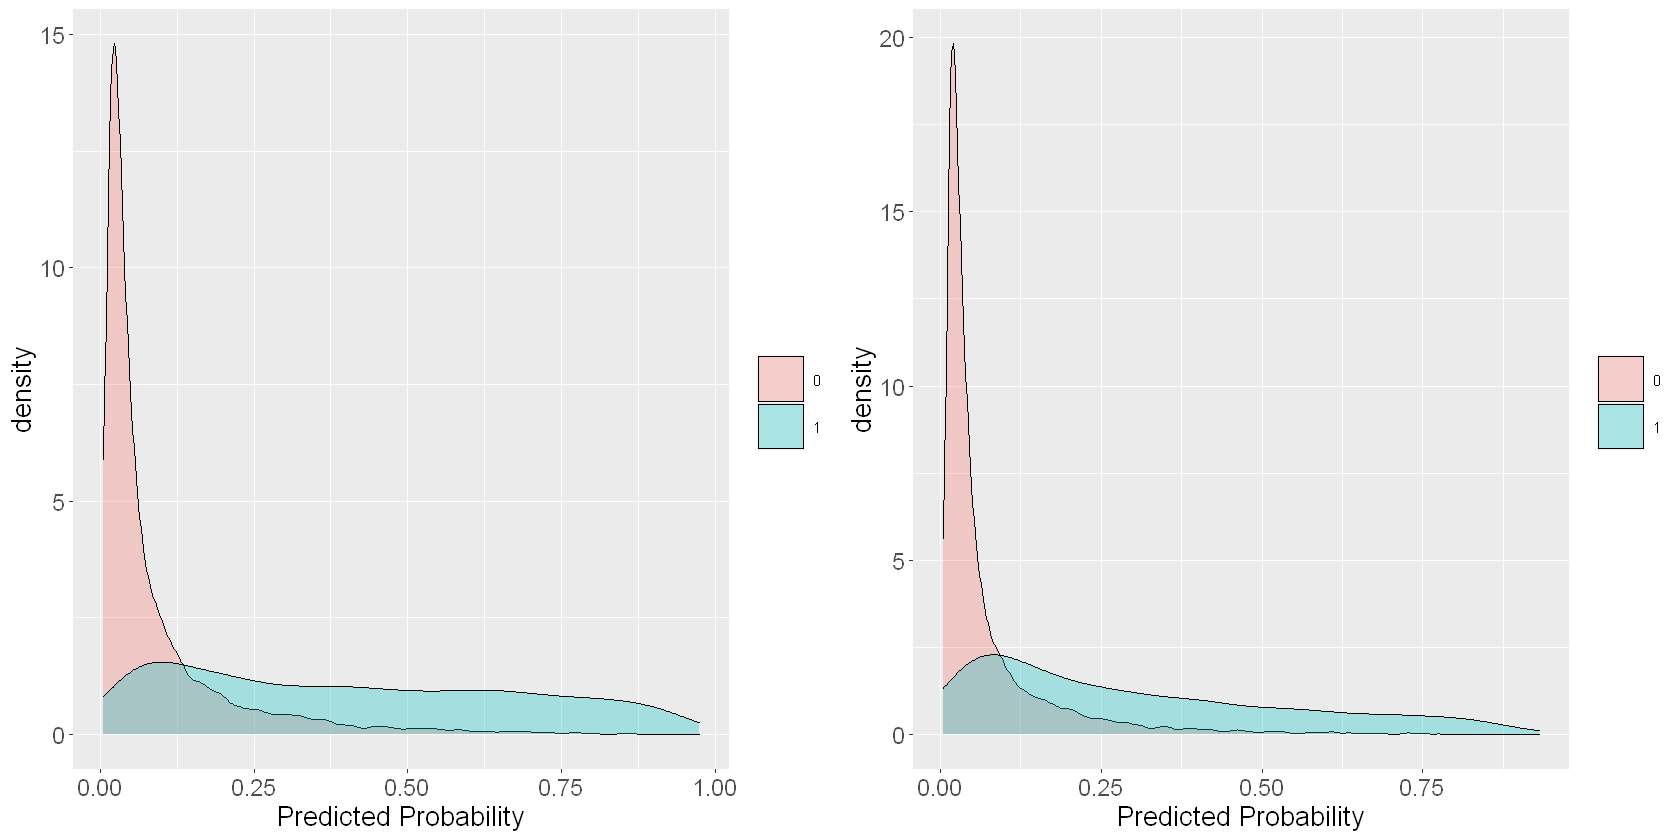

In [12]:
options(repr.plot.width=14, repr.plot.height=7)

# 1st and 2nd outcome (highest LOC or at 24th)
pmax <- plotfxn(X=coh_test$pred_death_24hr_max, Xlab="Predicted Probability", Fill=factor(coh_test$death_24hr_max_label), coh_test)
p24 <- plotfxn(X=coh_test$pred_death_24hr_recent, Xlab="Predicted Probability", Fill=factor(coh_test$death_24hr_recent_label), coh_test)

grid.arrange(pmax, p24, ncol=2)
# ggsave(file.path(resultdir,"Fig_pred_dens.png"), width = 14, height = 7, dpi = 1200) 

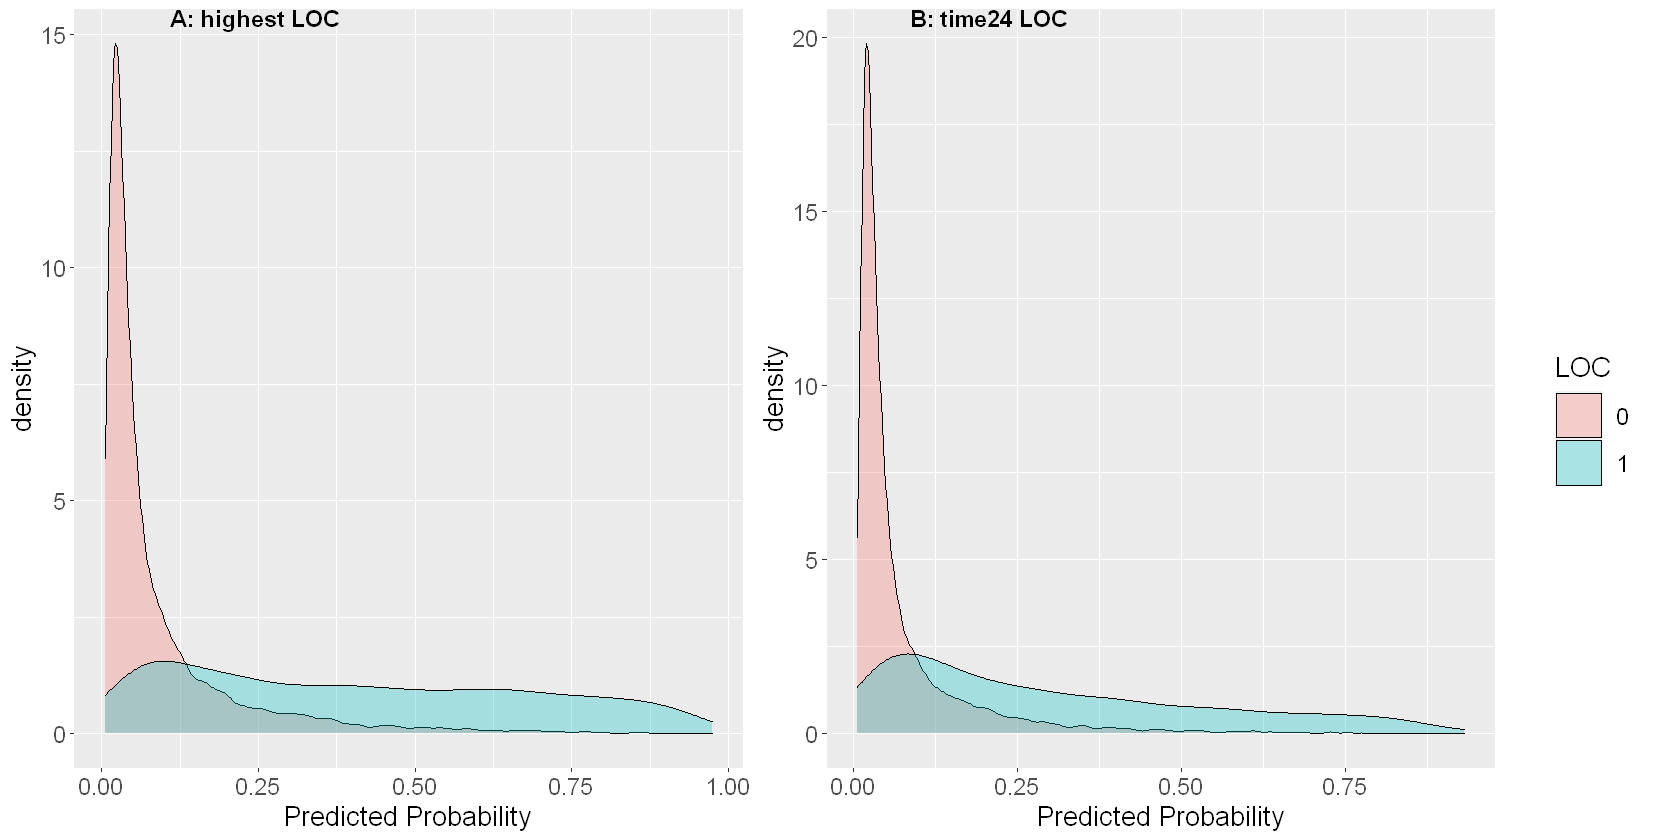

In [13]:
# 1st and 2nd outcome (highest LOC or at 24th), with labels, combined legends

prow <- plot_grid(
            plotfxn(X=coh_test$pred_death_24hr_max, Xlab="Predicted Probability", 
                    Fill=factor(coh_test$death_24hr_max_label), coh_test) +
                theme(legend.position="none"), 
            plotfxn(X=coh_test$pred_death_24hr_recent, Xlab="Predicted Probability", 
                    Fill=factor(coh_test$death_24hr_recent_label), coh_test) +
                theme(legend.position="none"),
            labels = c("A: highest LOC", "B: time24 LOC"),
            hjust = -1,
            nrow = 1
)

legend <- get_legend(
            plotfxn(X=coh_test$pred_death_24hr_max, Xlab="Predicted Probability", 
                    Fill=factor(coh_test$death_24hr_max_label), coh_test) +
            theme(legend.title = element_text(color = "Black", size = 16),
                  legend.text = element_text(color = "black", size = 14)
                 ) + scale_fill_discrete(name = "LOC")#+ theme(legend.box.margin = margin(0, 0, 0, 1))
)

plot_grid(prow, legend, rel_widths=c(6, 0.7))
ggsave(file.path(resultdir,"Fig_pred_dens.png"), width = 14, height = 7, dpi = 1200) 

In [15]:
# convert wide to long, entire test cohort
coh_test2 <- coh_test %>% rename(time0=pred_first, time24=pred_death_24hr_recent) %>% 
                select(-pred_death_24hr_max, -death_24hr_max_label)
coh_test2 <- gather(coh_test2, time, prediction, time0:time24, factor_key=TRUE)
head(coh_test2)

,pat_enc_csn_id_coded,first_label,death_24hr_recent_label,abs_diff0_24,transfer,time,prediction
,<dbl>,<int>,<int>,<dbl>,<int>,<fct>,<dbl>
1,131264906504,0,0,0.0,0,time0,0.2356759
2,131280664882,1,1,0.1,0,time0,0.9463215
3,131282861801,0,1,0.0,1,time0,0.6882317
4,131264837675,1,1,0.2,0,time0,0.6547346
5,131279238299,0,0,0.0,0,time0,0.3064106
6,131265866954,1,1,0.0,0,time0,0.7664736


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



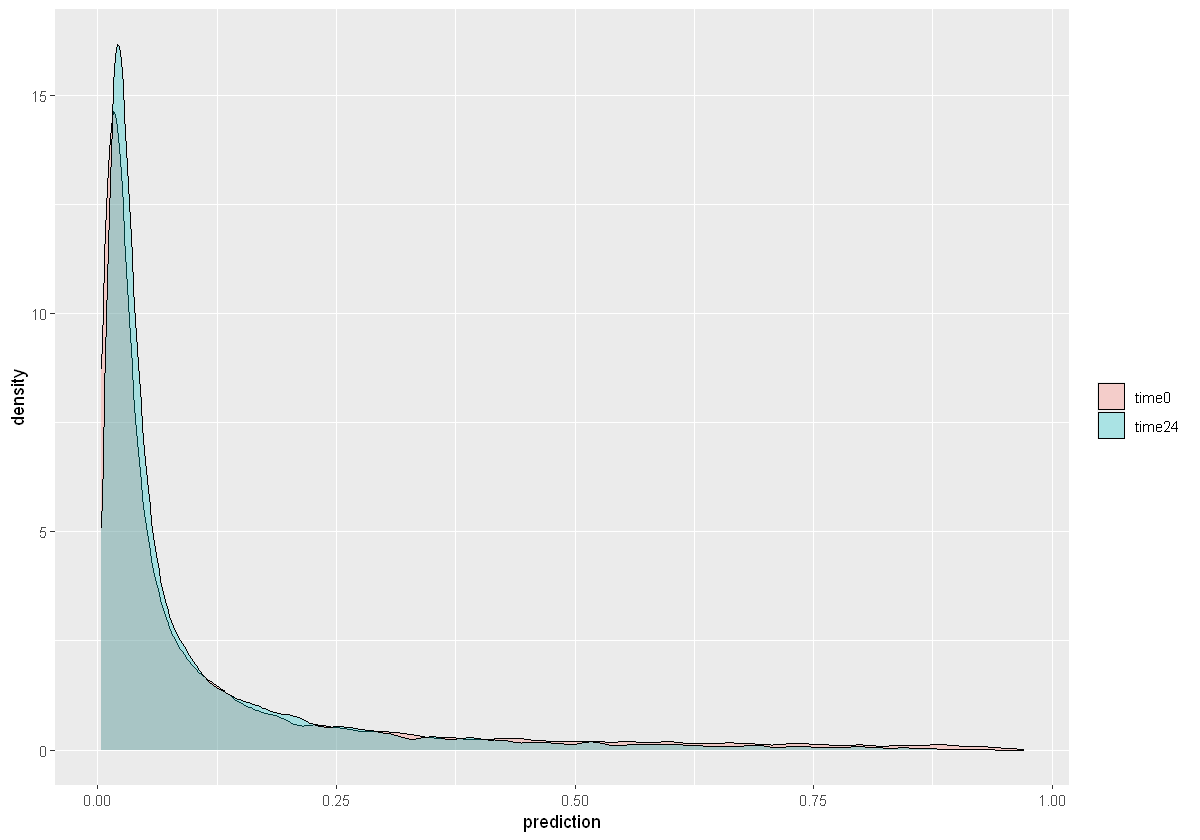

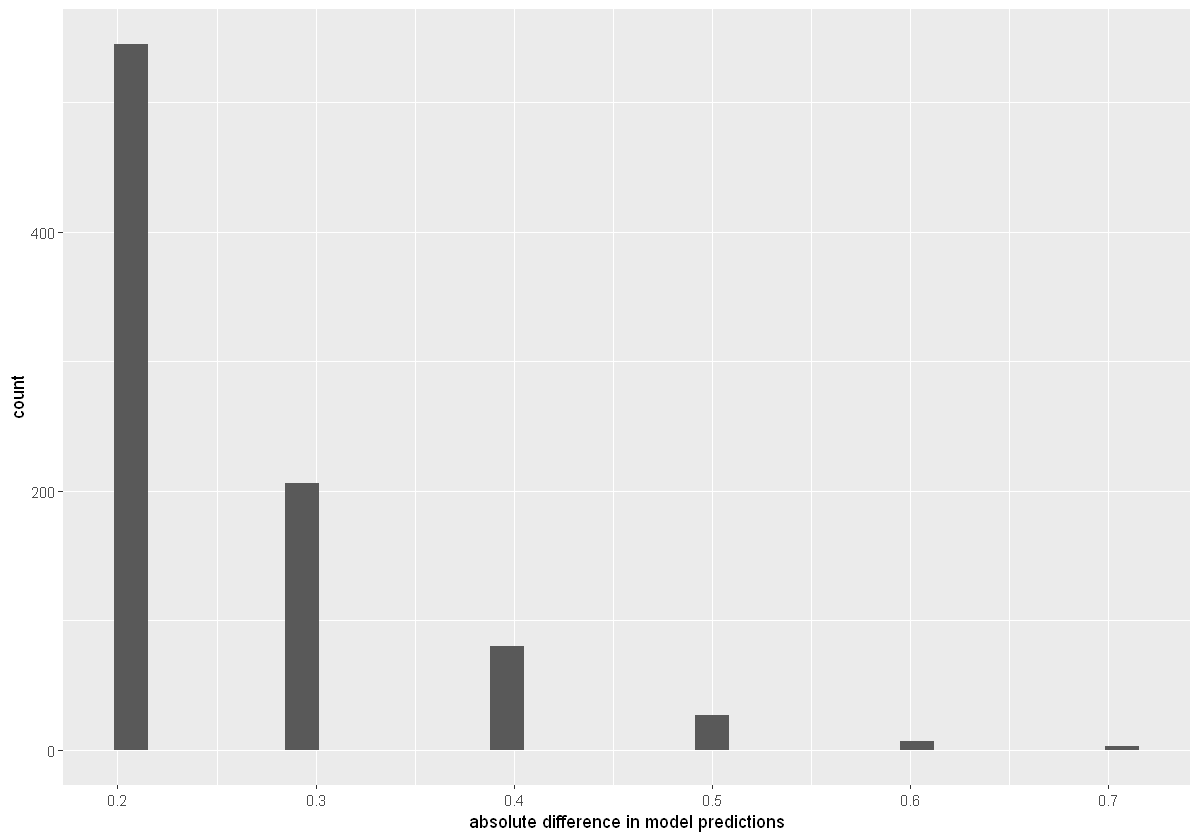

In [16]:
# hist(coh_test$abs_diff0_24)
# plotfxn(X=cohdis$pred_death_24hr_recent, Xlab="Predicted Probability", Fill=factor(coh_test$death_24hr_recent_label), coh_test)

options(repr.plot.width=10, repr.plot.height=7)

# test cohort, with abs difference btwn predicted values at time0 and time24 greater than 0.1
ggplot(data = coh_test2, aes(x=prediction, fill=time)) +
        geom_density(alpha=0.3, position = 'identity') + # color="#e9ecef", 
        labs(fill="")

ggplot(data = coh_test[coh_test$abs_diff0_24 > 0.1, ], aes(x=abs_diff0_24)) +
        geom_histogram() + xlab("absolute difference in model predictions")

In [14]:
# get discordance cohort abs_diff0_@4 >= 0.4
colnames(coh_test)
coh_dis <- coh_test %>% filter(abs_diff0_24 >= 0.4)
nrow(coh_dis)

[1] "pat_enc_csn_id_coded"    "first_label"            
[3] "death_24hr_max_label"    "death_24hr_recent_label"
[5] "pred_first"              "pred_death_24hr_max"    
[7] "pred_death_24hr_recent"  "abs_diff0_24"           
[9] "transfer"

[1] 117

In [16]:
# coh_dis[coh_dis$transfer==1, ]$pred_first
# coh_dis[coh_dis$transfer==1 & coh_dis$first_label==1, ]$pred_first

In [19]:
# discordance cohort, only with pred at time 24, not the primary outcome, wide to long
cohdis <- coh_dis %>% rename(time0=pred_first, time24=pred_death_24hr_recent) %>% 
            select(-pred_death_24hr_max, -death_24hr_max_label)

# get an index for each of the observations 
cohdis$idx <- rownames(cohdis)
nrow(cohdis)
head(cohdis)

# wide to long
cohdis2 <- gather(cohdis, time, prediction, time0:time24, factor_key=TRUE)
nrow(cohdis2)
head(cohdis2)

[1] 117

,pat_enc_csn_id_coded,first_label,death_24hr_recent_label,time0,time24,abs_diff0_24,transfer,idx
,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,131274348480,0,0,0.8106468,0.4368035,0.4,0,1
2,131281383883,1,1,0.5626119,0.1700678,0.4,0,2
3,131282719671,1,1,0.7961093,0.4289658,0.4,0,3
4,131284115343,1,1,0.5984289,0.2139906,0.4,0,4
5,131281707426,1,1,0.5319339,0.1795119,0.4,0,5
6,131263212928,0,0,0.6490586,0.2920811,0.4,0,6


[1] 234

,pat_enc_csn_id_coded,first_label,death_24hr_recent_label,abs_diff0_24,transfer,idx,time,prediction
,<dbl>,<int>,<int>,<dbl>,<int>,<chr>,<fct>,<dbl>
1,131274348480,0,0,0.4,0,1,time0,0.8106468
2,131281383883,1,1,0.4,0,2,time0,0.5626119
3,131282719671,1,1,0.4,0,3,time0,0.7961093
4,131284115343,1,1,0.4,0,4,time0,0.5984289
5,131281707426,1,1,0.4,0,5,time0,0.5319339
6,131263212928,0,0,0.4,0,6,time0,0.6490586


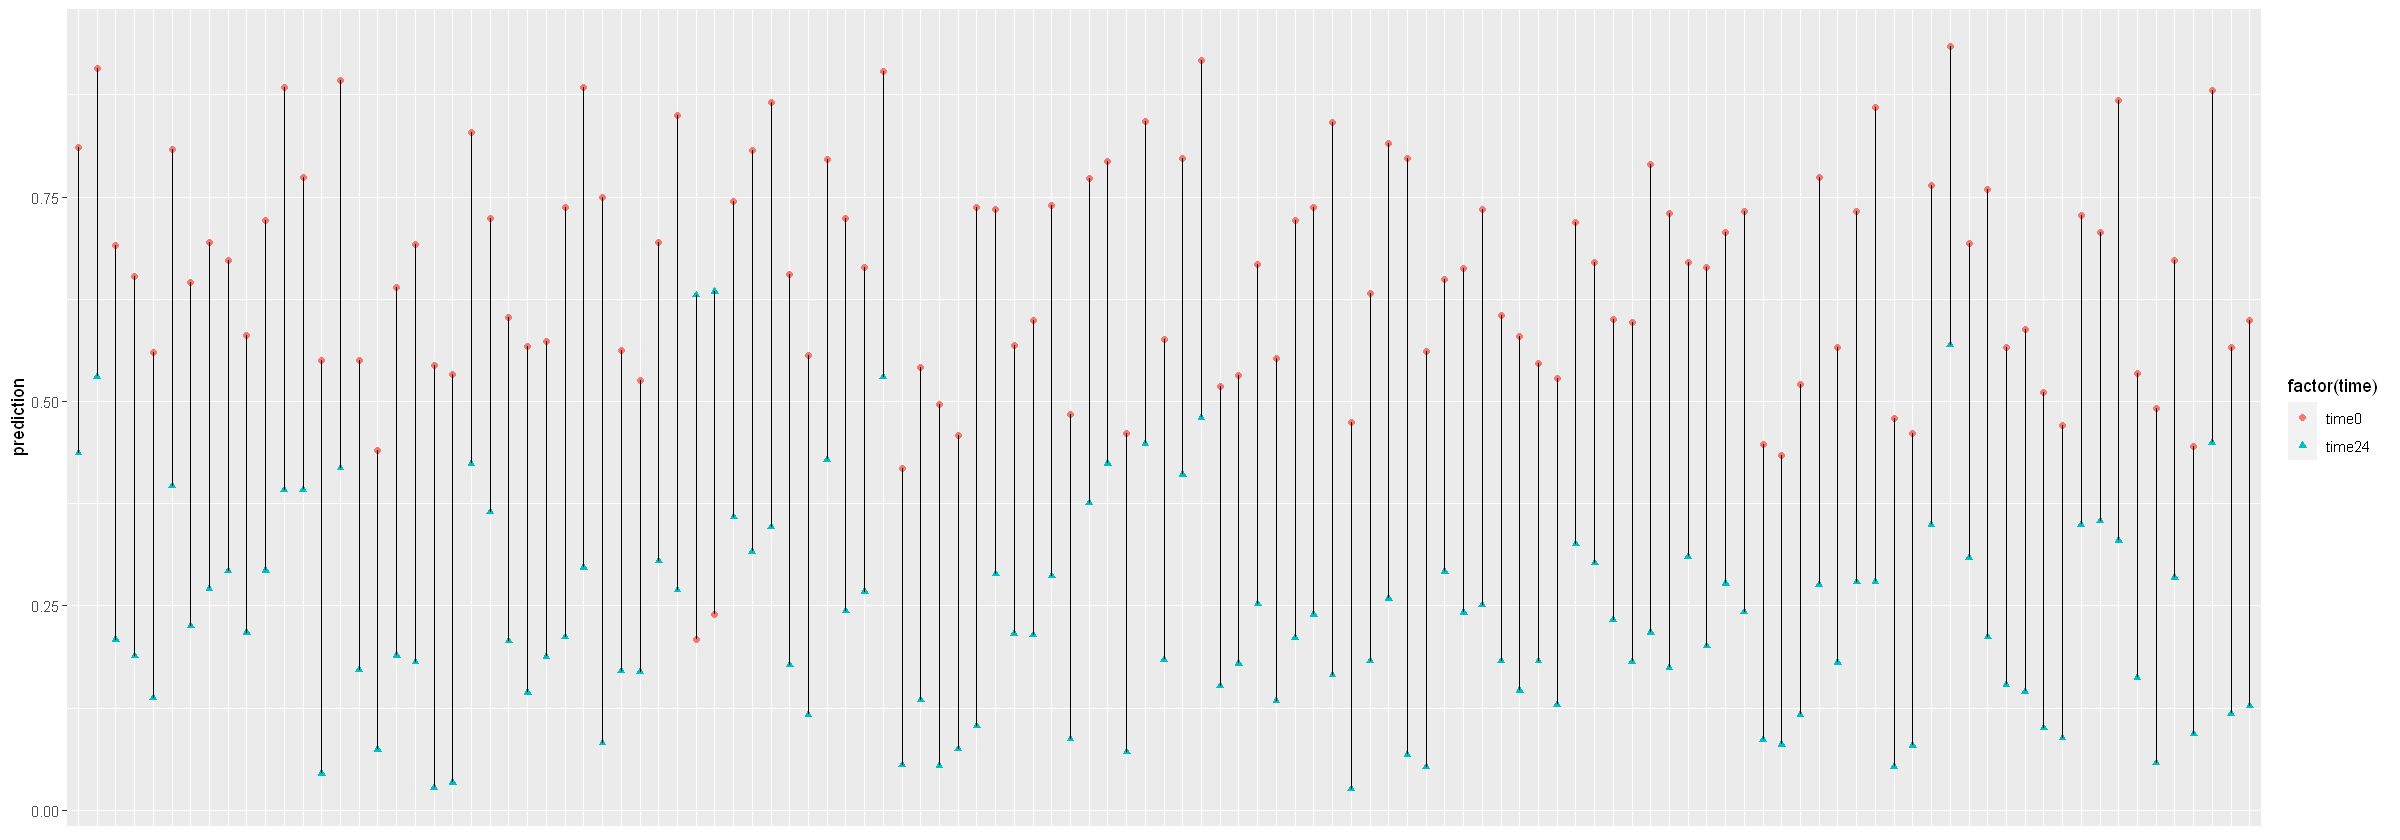

In [54]:
# all discordance >= 0.4 in pairs, not very informative
options(repr.plot.width=20, repr.plot.height=7)

p <- ggplot(cohdis2, aes(idx, prediction)) + 
        geom_point(aes(colour = factor(time), shape = factor(time))) + 
        geom_line(aes(group = idx)) +
        theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank())
p

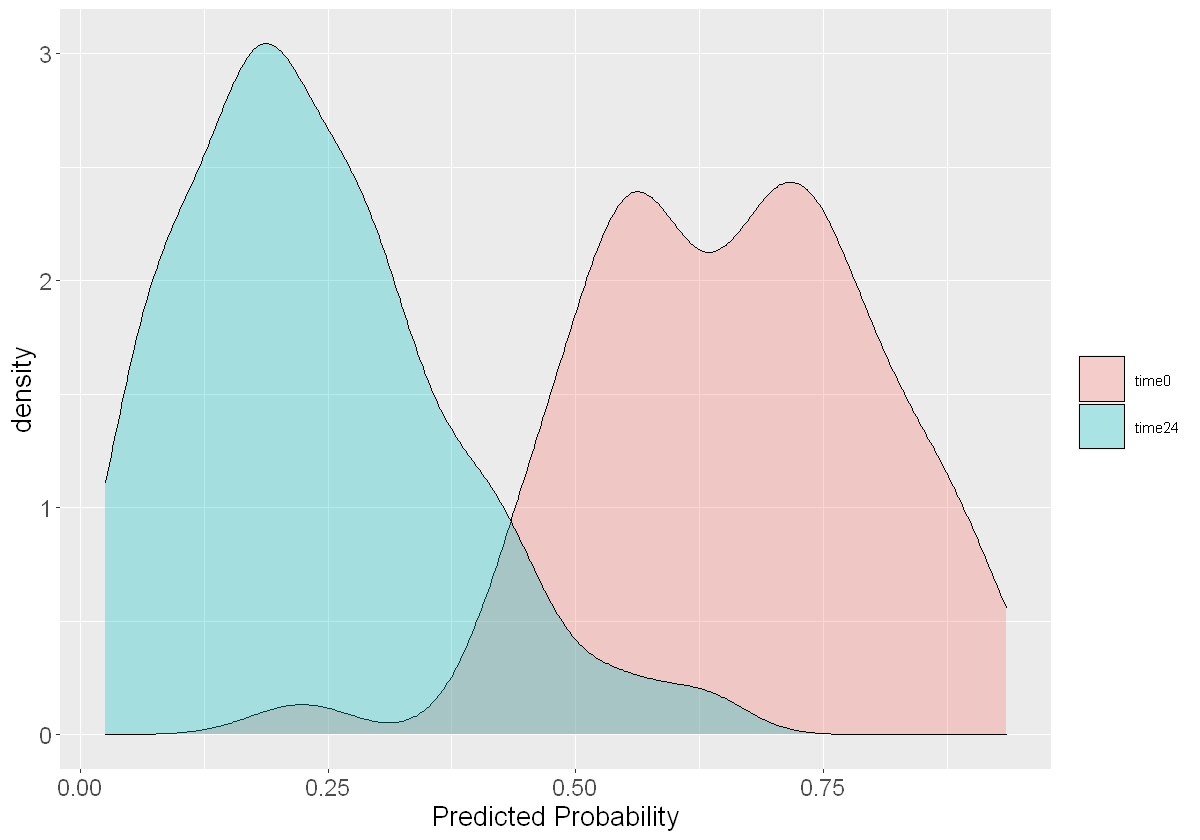

In [35]:
# density plot for prediction at time 0 and 24 for the discordance cohort
# time0 prob lean toward higher values and time24 leans toward lower values
plotfxn(X=cohdis2$prediction, Xlab="Predicted Probability", Fill=factor(cohdis2$time), cohdis2)

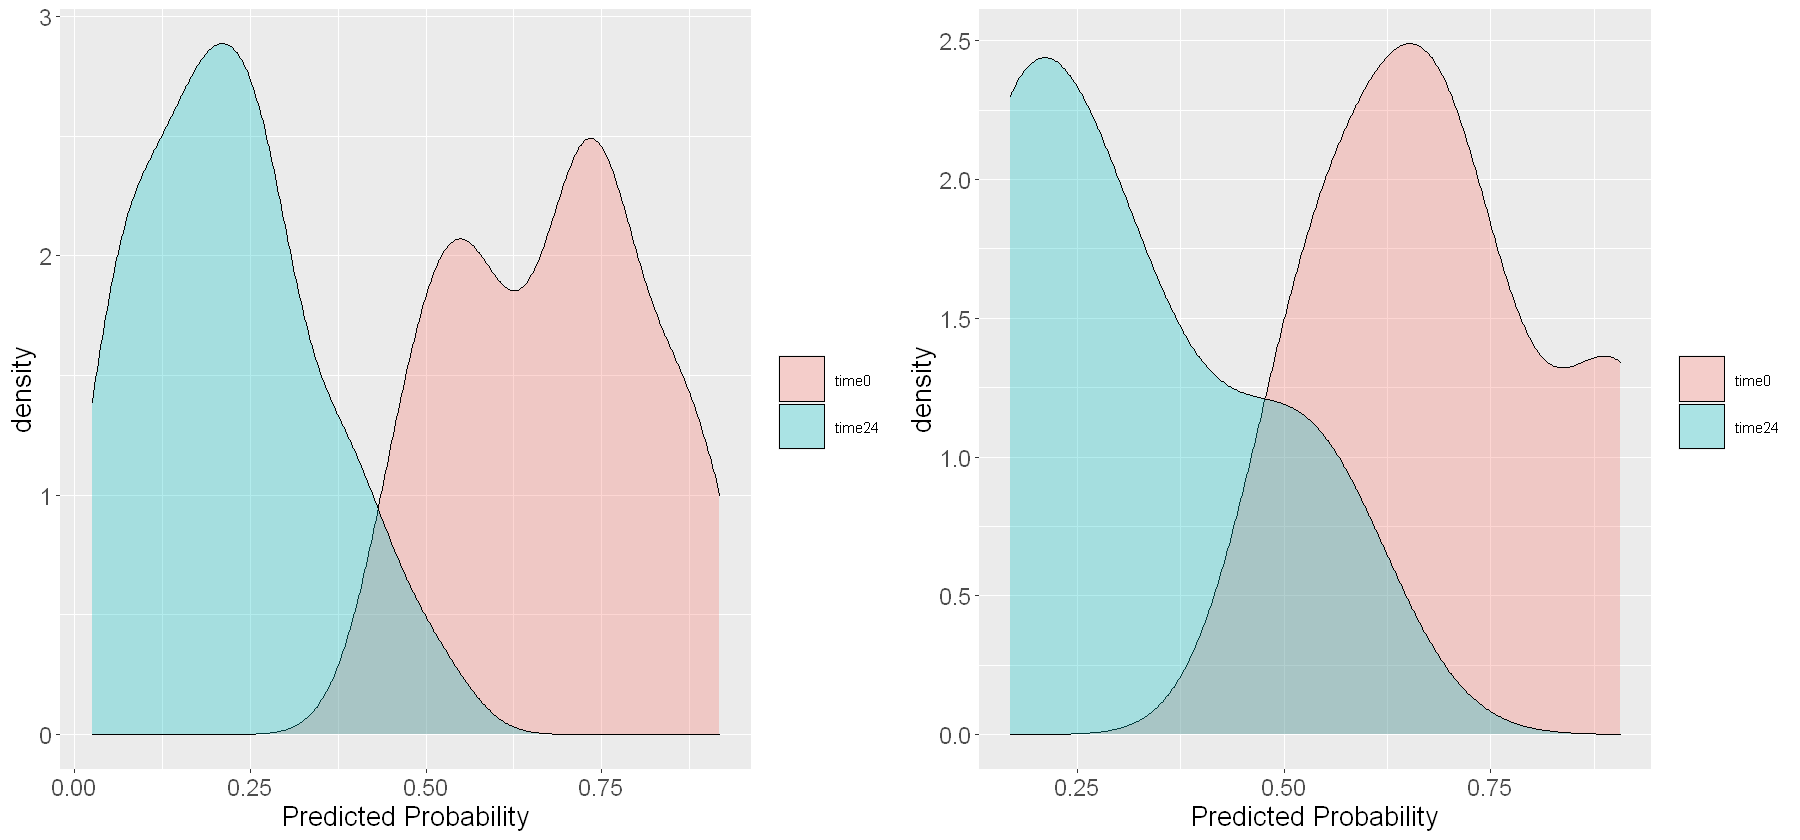

In [24]:
# coh_dis[coh_dis$transfer==1, ]$pred_first
# coh_dis[coh_dis$transfer==1 & coh_dis$first_label==1, ]$pred_first

# discordance cohort who did transfer
dtx10 = cohdis2[cohdis2$transfer==1 & cohdis2$first_label==1, ]
dtx01 = cohdis2[cohdis2$transfer==1 & cohdis2$first_label==0, ]

pdtx10 <- plotfxn(X=dtx10$prediction, Xlab="Predicted Probability", Fill=factor(dtx10$time), dtx10)
pdtx01 <- plotfxn(X=dtx01$prediction, Xlab="Predicted Probability", Fill=factor(dtx01$time), dtx01)

options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(pdtx10, pdtx01, ncol=2)

# ggsave(file.path(resultdir,"Fig_disc_tx_dens.png"), width = 14, height = 7, dpi = 1200) 

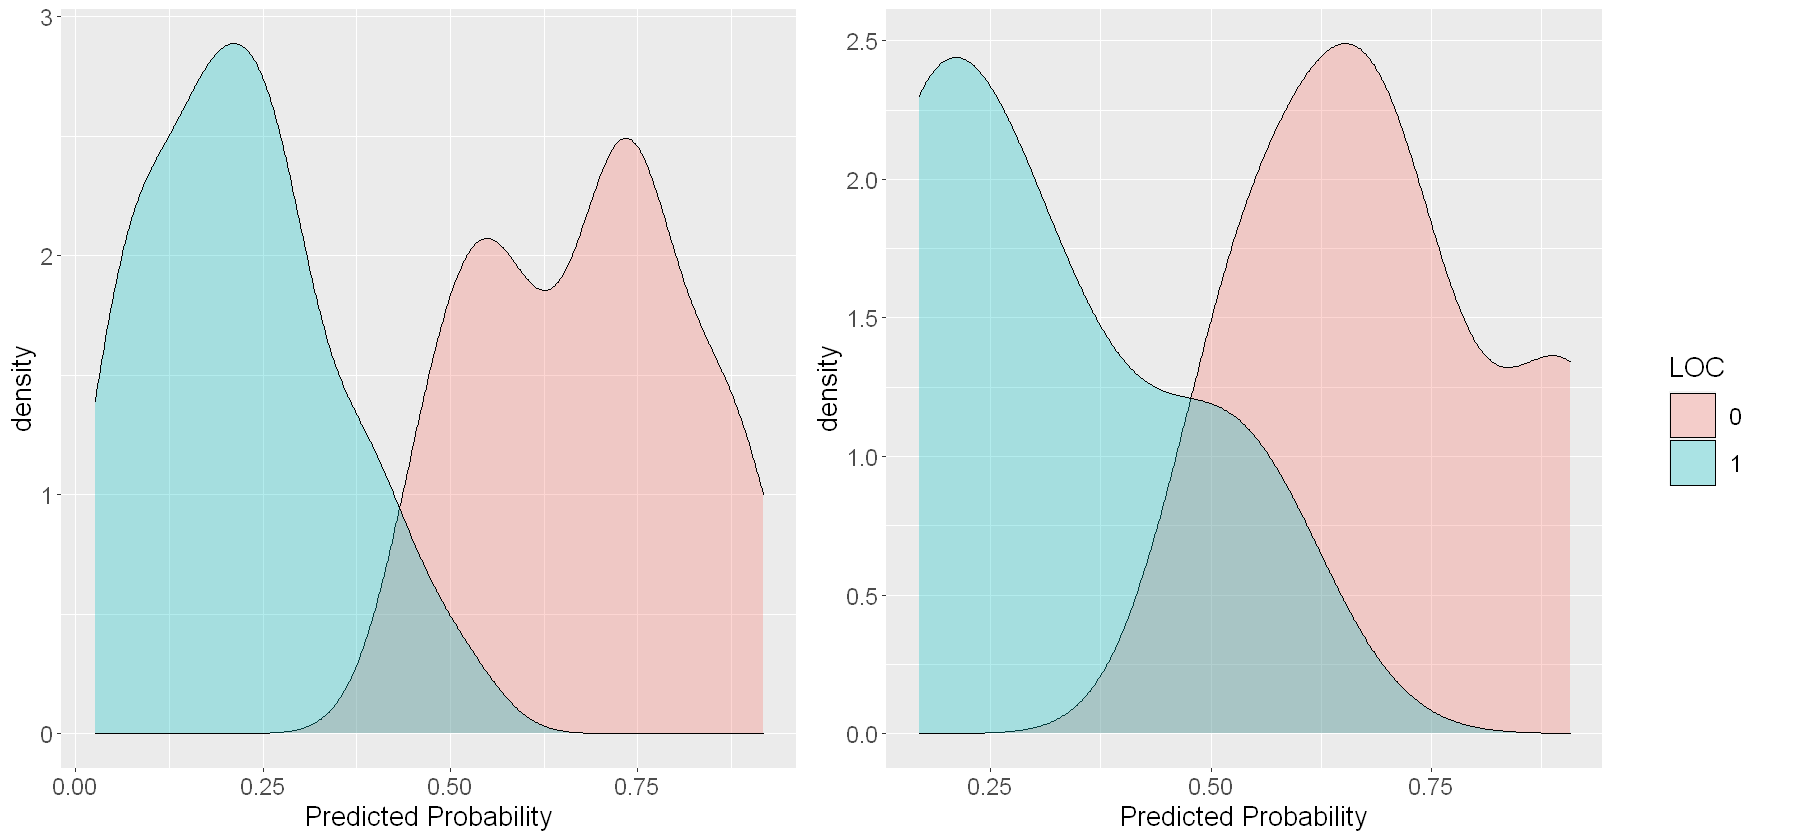

In [26]:
# remove duplicate legends

prowt <- plot_grid(pdtx10 + theme(legend.position="none"), pdtx01 + theme(legend.position="none"),
#             labels = c("A: highest LOC", "B: time24 LOC"),
            hjust = -1,
            nrow = 1
)

# legend <- get_legend(
#             plotfxn(X=coh_test$pred_death_24hr_max, Xlab="Predicted Probability", 
#                     Fill=factor(coh_test$death_24hr_max_label), coh_test) +
#             theme(legend.title = element_text(color = "Black", size = 16),
#                   legend.text = element_text(color = "black", size = 14)
#                  ) + scale_fill_discrete(name = "LOC")#+ theme(legend.box.margin = margin(0, 0, 0, 1))
# )
plot_grid(prowt, legend, rel_widths=c(6, 0.7))

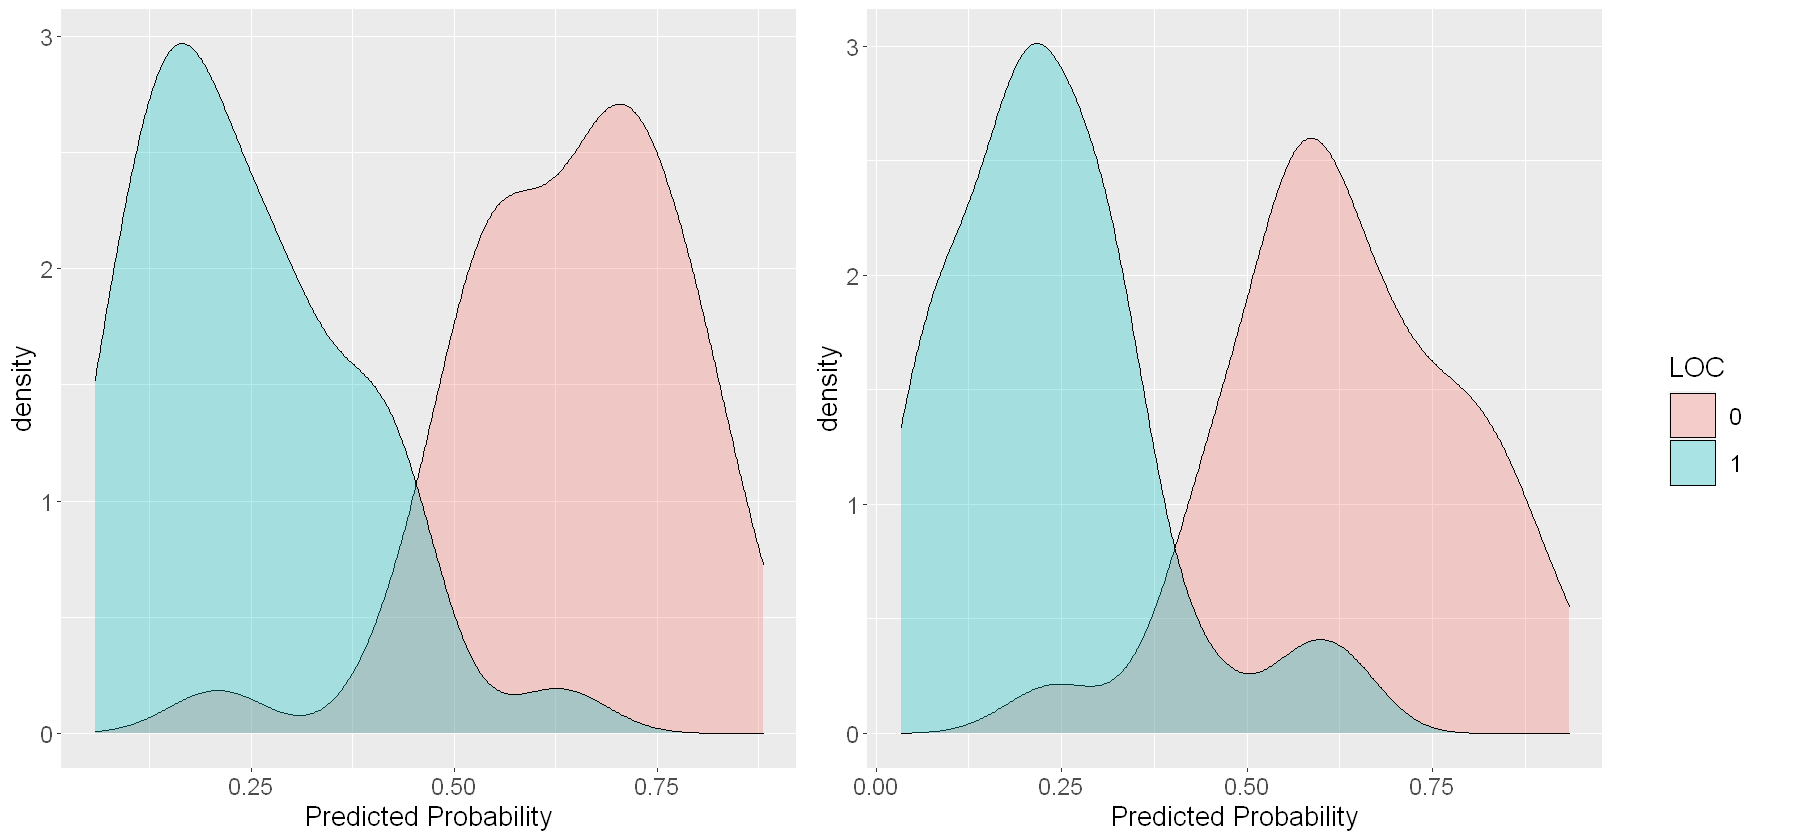

In [28]:
# discordance cohort who did not transfer
# remove duplicate legends

d1 = cohdis2[cohdis2$transfer==0 & cohdis2$first_label==1, ]
d0 = cohdis2[cohdis2$transfer==0 & cohdis2$first_label==0, ]

pd1 <- plotfxn(X=d1$prediction, Xlab="Predicted Probability", Fill=factor(d1$time), d1)
pd0 <- plotfxn(X=d0$prediction, Xlab="Predicted Probability", Fill=factor(d0$time), d0)

# plot
options(repr.plot.width=15, repr.plot.height=7)
# grid.arrange(pd1, pd0, ncol=2)

prowd <- plot_grid(pd1 + theme(legend.position="none"), pd0 + theme(legend.position="none"),
#             labels = c("A: highest LOC", "B: time24 LOC"),
            hjust = -1,
            nrow = 1
)

plot_grid(prowd, legend, rel_widths=c(6, 0.7))
# ggsave(file.path(resultdir,"Fig_disc_notx_dens.png"), width = 14, height = 7, dpi = 1200) 

### check LOS and death
This has less than the full cohort

In [29]:
head(los)

,anon_id,pat_enc_csn_id_coded,admit_time,first_ED_time,discharge_time,length_of_ip_since_admit,length_from_ED_entry_until_discharge,death_date_jittered,died_before_discharge
,<chr>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,JCe78a06,131062667066,2015-01-02 01:01:00,2015-01-01 17:10:00+00:00,2015-01-11 23:40:00+00:00,9 days 22:39:00,10 days 06:30:00,2020-01-10 00:00:00+00:00,
2,JCd1c19e,131062745090,2015-01-03 05:53:00,2015-01-03 01:56:00+00:00,2015-01-07 02:00:00+00:00,3 days 20:07:00,4 days 00:04:00,,
3,JCd91eb2,131062747648,2015-01-01 08:24:00,2015-01-01 01:10:00+00:00,2015-01-06 03:19:00+00:00,4 days 18:55:00,5 days 02:09:00,2019-01-01 00:00:00+00:00,
4,JCe7cb4d,131062788358,2015-01-01 23:39:00,2015-01-01 17:07:00+00:00,2015-01-22 01:25:00+00:00,20 days 01:46:00,20 days 08:18:00,,
5,JCe293de,131063044001,2015-01-05 02:23:00,2015-01-04 18:13:00+00:00,2015-01-05 22:30:00+00:00,0 days 20:07:00,1 days 04:17:00,,
6,JCe8d756,131063080858,2015-01-07 04:00:00,2015-01-06 22:24:00+00:00,2015-01-09 21:00:00+00:00,2 days 17:00:00,2 days 22:36:00,,
